In [1]:
import numpy as np
from scipy import optimize
import numba
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

#_ = np.seterr(all='raise') # turn all numpy floating point errors into exceptions

## Notes

What defines equilibrium? 
1. Thermal Equilibrium: $T_S=T_L$ at the mutual interface (LR87 eqn 4.55). They also suggest at the start of section 4.3.1. that $F\Rightarrow\infty$ is required but we don't know what $F$ is. I think its in 4.45 and is something to do with entropy. 
2. Chemical equilibrium: $\mu_S = \mu_L$. Since $T$ and $p$ are equilibrated and flow near the surface of the solid is inhibited this is governed by diffusion in the chemical BLs on their side of the interface. 
3. Phase equilibrium: $\Lambda = \infty$. At phase equilibrium the rate of formation of solid will match the rate of destruction of solid because the total free energy will be minimised. That is to say, the volume of solid and the volume of liquid will be determined by applying the leaver rule to the phase diagram. This is what Sun is giving us below. The timescale is the sum of growth and nucleation timescales. The solid fraction is fixed and this is composed of $N$ particles: How long does it take to nucleate these $N$ particles and grow them to their equilibrium size? 

<ins>(1) and (2): solid</ins>. In this case the relevant lengthscale is the particle radius $r$. Assuming (with reasonable justification) that there is no internal motion the only available dynamical timescale is that of diffusion and we can write the thermal and chemical diffusion timescales for the solid as 

$$ \tau_T^s = \frac{r^2}{\kappa_s} , \quad \tau_C^s = \frac{r^2}{D_s} , $$ 

where $\kappa_s$ is the thermal diffusivity in the solid and $D_s$ is the self-diffusion of an impurity in the solid phase. 

<ins>(1) and (2): liquid</ins>. Here the relevant lengthscales are determined by the thickness of the thermal, chemical and momentum boundary layers, $\delta_T^l$, $\delta_C^l$ and $\delta_u$ respectively. Assuming that diffusion is the dominant transfer mechanism in the boundary layer, the relevant timescales are: 

$$ \tau_T^l = \frac{\delta_T^2}{\kappa_l} , \quad \tau_C^l = \frac{\delta_C^2}{D_l} , $$ 

where the equations now use the diffusion coefficients in the liquid, subscript $l$.  We will also use results from Inman et al (https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/deformation-of-ambient-chemical-gradients-by-sinking-spheres/35989F950D19A495C5FBCECED733A875),who considered an isolated sphere sinking through a chemically stable gradient. In the following $Pe_T = 2r U / \kappa = PrRe$ and $Pe_C = 2r U / D_L = ScRe$ are the thermal and chemical Peclet numbers, $Pr = \nu / \kappa$ is the Prandtl number, $Sc = \nu / D_l$ is the Schmidt number and $U$ is the velocity of the sphere. Note that this is the same definition as used by Zhang and Xu (2002) below.  

There are several cases, but we can reduce these by noting that in the core $Sc \gg 1$ and $Pr \sim 1$. The cases for $Sc\gg1$ are:  

a) Low $Re$ ($<10^{-2}$): This is important for particles $\lesssim 10^{-4} - 10^{-5}$ m. The scalings are not entirely clear but Fig 7a of Inman suggests

$$ \frac{\delta_u}{2r} \sim \frac{\delta_C^l}{2r} \sim \frac{\delta_T^l}{2r} \sim 1$$

The idea is that at low enough $Re$, $Pe_C$ should be small even if $Sc$ is large. Since $Sc\sim 100 - 1000$ in the core, $Pe_C\sim 1$ at $Re\sim 10^{-2}-10^{-3}$. For the thermal case, one could argue that $Pe_T\sim 1$ at $Re\sim 100$. In the limit of low $Pe$ there is nothing in the boundary layer equation to balance diffusion since the advection terms cannot adopt shorter lengthscales. (At high $Pe$ the balance is achieved because diffusion acts onshort lengthscales). Instead there is simply no boundary layer. Conduction is dominant everywhere. 

b) Intermediate $Re$ ($10^{-2} \le Re \le 10^2$): Inman et al (2020) eqn (3.7)

$$\frac{\delta_u}{2r} \sim 1, \quad \frac{\delta_C^l}{2r} \sim Pe_C^{-1/3}, \quad \quad \frac{\delta_T^l}{2r} \sim Pe_T^{-1/2} $$

c) High $Re (>200)$: See below eqn (3.5) of Inman et al (2020). 

$$\frac{\delta_u}{2r} \sim Re^{-1/2}, \quad \frac{\delta_C^l}{2r} \sim Re^{-1/2} Sc^{-1/3}, \quad \frac{\delta_T^l}{2r} \sim (RePr)^{-1/2}$$

Note that in this case the Grossmann and Lohse (2000) theory predicts

$$ \frac{\delta_T}{2r}\sim Nu^{-1} \quad \mbox{and} \quad Nu \sim (RePr)^{1/2} \quad \mbox{if}  \quad \delta_u < \delta_T \quad \mbox{or} \quad  Nu \sim Re^{1/2}Pr^{1/3} \quad \mbox{if} \quad \delta_u > \delta_T$$

where $Nu$ is the Nusselt number. This is consistent with the Inman results. 

<ins>(3): Phase equilibrium</ins>: Equilibrium conditions give the volume fraction $V_E(T)$ of solid that corresponds to the state where chemical potentials in the solid and liquid are equal. However, there are an infinity of ways to partition $V_E$ between $N$ particles of radius $r$; the end-member cases are a large number of small particles and a small number of large particles. Additional information is needed. 

Here we will assume that the inner core is built from snow leaving the base of the F-layer. The snow is assumed to fall at the Stokes velocity $V_s$. We will assume that the inner core growth rate $d r_i / dt$ is given. Then the total volume change in time $d t$ is $d V / d t = 4\pi r_i^2 (d r_i /dt)$. The volume change (assuming spherical growth) is the number of particles flowing to the ICB at the Stokes velocity, which is $\frac{4\pi r^3}{3} N P V_s$, where the packing fraction $P=0.69$ for spheres. The two conditions corresponding to phase equilibrium and inner core growth are then

$$ V_E(T) = \frac{4 \pi r^3 N}{3} (1) , \quad \frac{4\pi r^3}{3} N P V_s = 4\pi r_i^2 \frac{d r_i}{dt} (2) ,$$

where $V_s$ is the generalised Stokes velocity as defined in Zhang and Xu (2002 - see below). Note that $r$ is not eliminated between these two equations because $V_s$ contains factors of $r$. 

To undertake the calculation there is the additional constraint that the particles must fall a maximum distance $\Delta r$ corresponding to the F-layer depth slower than the timescale required to reach phase equilibrium. If this is not true then the assumptions underlying the calculation (for a given IC growth rate) are incorrect. This comes into the calculation via $V_E$, which is actually the volume of solid in equilibrium divided by the total volume (i.e. the volume containing particles that can make it to the ICB). 

For a given $\Delta r$ and the $V_s$ obtained from equations (1) and (2) we can estimate the time $\tau_f$ it takes the particles to fall to the ICB. 

In fact equation (1) is actually $M$ constraints, one for each temperature $T(r)$. This is a problem because the second equation is only one constraint. To show this, consider that the F-layer is comprised of 2 levels, each with equilibrium volume, mean particle radius and mean particle number denoted $V_i$, $r_i$ and $N_i$ respectively, with $i = 1, 2$. The equations then become

$$ V_1 = \frac{4 \pi r_1^3 N_1}{3}$$ 
$$ V_2 = \frac{4 \pi r_2^3 N_2}{3}$$ 
$$\frac{4\pi r_1^3}{3} N_1 P V_{s1} + \frac{4\pi r_2^3}{3} N_2 P V_{s2} = 4\pi r_i^2 \frac{d r_i}{dt} ,$$

There are now 4 unknowns ($N_i$ and $R_i$) but only 3 equations. Further constraints are needed, but at present we are not sure what they are. 

<ins>(3a): Nucleation timescale</ins>:

The timescale to reach phase equilibrium, $\tau_E$, at radius $r$ with number of particles $N$ is approximately (might be a factor of 2 knocking about)

$$\tau_E(r,N) = \tau_N + \tau_G $$

where $\tau_N$ and $\tau_G$ are respectively the nucleation and growth timescales. 

$$ \tau_G = \frac{r}{V(T)}, \mbox{ where } V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right]$$

Problem here is that $\tau_N$ is the probability of nucleating 1 particle and we need the probability of nucleating $N$ particles. For $\tau_G$ we need to account for the fact that not all particles nucleate at the same time.  

For $\tau_N$ the critical radius is

$$ r_c \simeq - \frac{2\gamma T_m} {h_f  h_c(\delta T) \delta T}, $$

and is therefore a function of the interfacial energy $\gamma$ and the critical undercooling temperature $\delta T$: the closer the temperature to $T_m$ the larger the critical radius. The number of embryos of critical size $r_c$ per unit volume per unit time is

$$ I = I_0 \exp \left [ -\frac{16}{3}\frac{\pi \gamma^3 T_m^2}{k_{\rm B} T \delta T^2 h_f^2 [h_c(\delta T)]^2} \right ] $$
where $I_0$ is a prefactor which is related to the number of atoms per unit volume and an attempt frequency of bringing atoms together to form a solid embryo.

"Since they are at the top of the free energy barrier, on average approximately half of the embryos will re-melt, and the other half will grow and lead to a freezing event. The average waiting time to observe a freezing event, $\tau_N (units of s~m~$^3$), is therefore"

$$ \tau_N = \frac{1}{2 I_0} \exp \left [ \frac{16}{3}\frac{\pi \gamma^3 T_m^2}{k_{\rm B} T \delta T^2 h_f^2 [h_c(\delta T)]^2} \right ]. $$

Old notes of phase equilibrium: The timescale is the time taken for a liquid to reach phase equilibrium if it was instantly transported to defined temperature where solid and liquid were in equilibrium for a given particle size. To do this we would need to:
- Calculate the volume of solid for equilibrium from the free energy curves for the solid and liquid. If impurities partition between the solid and liquid this gets numerically complicated (see my ppv/pv notebook in LEMA!) but is really just a constrained minimisation problem. If we assume impurities only go in the liquid this should be much easer. For a pure single chemical component system phase equilibrium will always be 100% solid or 100% liquid.
- Work out how many particles of radius r we need to make the volume in (1). Work out how long it takes to form this volume of solid by nucleating the required number of particles and growing them by r. This is the timescale for phase equilibrium we need for the figure. At small r we will need many particles and so the time should be dominated by nucleation. At large radius, we will need fewer particles but they will need more time to grow, so time should be dominated by growth. In either case, the first thing we need is a function to give us the time to make a number of nuclei at a given temperature. We just need to add this line to the red line we have to get the anCalculate the volume of solid for equilibrium from the free energy curves for the solid and liquid. If impurities partition between the solid and liquid this gets numerically complicated (see my ppv/pv notebook in LEMA!) but is really just a constrained minimisation problem. If we assume impurities only go in the liquid this should be much easer. For a pure single chemical component system phase equilibrium will always be 100% solid or 100% liquid.
- Work out how many particles of radius r we need to make the volume in (1). Work out how long it takes to form this volume of solid by nucleating the required number of particles and growing them swer.

<ins>(3) revisited:</ins>
In LR world it is assumed that there is a slurry, i.e. a two-phase system, that is initially out of equilbrium. The question is: how long does it that this system to reach equilibrium. In this case the nucleation TS is irrelevant and only growth matters. Then the calculation is simply the Sun calculation. 

LR87: On pg 69 (bottom) they argue that "it would be more consistent to suppose that thermal and phase equilibrium proceed at a similar rate - see 3.2.2.". 

## Some papers of minor relevance: 

Janudom, S., Wannasin, J., Basem, J. and Wisutmethangoon, S., 2013. Characterization of flow behavior of semi-solid slurries containing low solid fractions in high-pressure die casting. Acta materialia, 61(16), pp.6267-6275.
- "In literature, all the studies of semi-solid metal die filling were conducted with high initial solid fractions in the range of 30–60% [1,5,6]...For semi-solid slurry with low initial solid fractions of less than 15%, however, no studies have been reported. With these very low initial solid fractions, the flow behavior of semi-solid slurries is quite complicated. The initial solid fraction starts from a very low fraction in the range of 3–15% when it is poured into a shot sleeve. The solid fraction then abruptly increases to a higher value in the shot sleeve and then in the die."
- They realise solid fractions as low as 3% in experiements and do simple characterisation of the flow, but no detailed analysis or comparison with theory.  

Chen, J.Y. and Fan, Z., 2002. Modelling of rheological behaviour of semisolid metal slurries Part 1–Theory. Materials Science and Technology, 18(3), pp.237-242.
- Says that "liquid-like"slurries are generally referred to as semi-solid metal slurries. 
- Could ultimately be interesting. They develop a micro-scale rheological model based on agglomeration. 
- However, as far as I could tell, there is no melting/freezing. 

In [2]:
# Define parameters
secinyr = 60.0*60.0*24.0*365.0
k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)              # thermal diffusivity of liquid
Dliq  = 1e-9                     # self-diffusion of O in liquid
Dsol  = 1e-12                    # self-diffusion of O in solid
mu    = 1e-6                     # kinematic viscosity
drho  = rhos-rhol                # density difference
g     = 3.7                      # gravity at ICB from PREM
Vic      = 4 * np.pi * 1221000.0**3 / 3.0  # IC volume
kb       = 1.380648e-23          # Boltzmann constant
secingyr = 3.1536e+16      
ri       = 1221e3
rf       = ri + 200e3

Tm = 5500.0                      # Default melting temperature at the ICB

Vic = 4.0*np.pi*ri**3 / 3.0
Vsl = 4.0*np.pi*(rf**3 - ri**3) / 3.0

Pr = mu / kappa
Sc = mu / Dliq
print("Pr = ", Pr, ' Sc = ', Sc)

r = np.logspace(-8,3,num=100)     # Array of particle sizes in metres

Pr =  0.09075  Sc =  999.9999999999999


In [3]:
# Calculate diffusion and freefall timescales
tt = np.zeros(len(r))  # Thermal diffusion time
ts = np.zeros(len(r))  # Chemical diffusion in solid
tl = np.zeros(len(r))  # Chemical diffusion in liquid
tVl= np.zeros(len(r))  # Timescale based on Stokes velocity Vs

# All timescales in yrs
j = 0
for i in r:    
    tt[j] = i**2/kappa/secinyr
    ts[j] = i**2/Dsol/secinyr
    tl[j] = i**2/Dliq/secinyr
    
    Vs    = 2.0 * drho * g * i**2 / (9.0 * mu * rhol)
    tVl[j]= 100e3/Vs/secinyr
    
    #print("{:e}".format(i), "{:e}".format(tt), "{:e}".format(ts), "{:e}".format(tl))
    j = j + 1

## Falling timescale of slurry patricles. 

A key question is whether patricles of a given radius $r$ will fall out of the slurry before they can equilibrate with their surroundings via diffusion. The simplest estimate is based on Stokes flow, which gives the terminal velocity of the partickle by balancing buoyancy and drag forces and applies at low Reynolds number $Re$. Zhang and Xu (2003, https://www.sciencedirect.com/science/article/pii/S0012821X03002978?casa_token=sjZhMFVPcuMAAAAA:89Txq8oZeXVy3-pyY7nqj942kzd95iOZKYyELUrlthZ-nM7vzabhz-F8trUMdFLXnim9N6A2Jkg) summarise and extend previous results to high $Re$ and so we consider both cases. 

The classical Stokes flow velocity is given by

$$ V_S = \frac{2}{9} \frac{\Delta \rho g a^2}{\mu} $$

while the Zhang and Xu equation (20) gives

$$ V_Z = \sqrt{\left( \frac{8}{3} \frac{\Delta \rho g a}{\rho_l C_D} \right) }$$

The drag coefficient $C_D$ is 

$$ C_D = \frac{2F_D}{\rho_l V^2 A} V$$

If $F_D = 6\pi \mu a$ as given by Stokes drag then we can take $V=V_z$ in the equation for $C_D$, which becomes $C_D = (12 \pi \mu a) / (\rho_l V_Z A)$. Subbing into the original eqn for $V_Z$ and noting that the area $A\sim\pi a^2$ we recover the Stokes velocity.

As $Re$ increases the drag coefficient increases and so $V_Z$ tends to decrease compared to $V_S$. Hence the falling time should be greater for the high $Re$ case than the low $Re$ case at high $Re$. This provides a check on the results below. 

In [4]:
# For given velocity outputs the Reynolds number Re and drag coefficient Cd. 
# Used to check fzhang_opt: if fzhang_opt has found the velocity that solves the equations
# then input u = output u

def fzhang(u,r):
    """
    r  = particle radius
    u  = initial velocity guess
    mu = kinematic viscosity
    Re = Reynolds number
    Cd = drag coefficient
    g  = gravity at ICB
    drho = solid-liquid density difference
    rhol = liquid density
    """
    
    Re  = np.abs(2*r * u / mu)                                              # Eqn 1  of ZX02
    Cd  = (24.0/Re) * (1.0 + 0.15*Re**0.687) + 0.42/(1.0 + 42500*Re**-1.16) # Eqn 19 of ZX02
    unum= 8.0 * g * r * drho                                                # Eqn 20 of ZX02
    uden= 3.0 * rhol * Cd                                                   # Eqn 20 of ZX02
    u   = np.sqrt(unum/uden)
    return Re, Cd, u

In [5]:
# Finds the velocity, "result", based on an initial guess u using the eqns in Zhang and Xu (2003)

def fzhang_opt(u,rad):
    """
    rad= particle radius
    u  = initial velocity guess
    mu = kinematic viscosity
    Re = Reynolds number
    g  = gravity at ICB
    drho = solid-liquid density difference
    rhol = liquid density
    """
    
    re = np.abs(2*rad*u/mu)

    result = (8.0 * g * rad * drho) / (3.0 * rhol * 
          ( (24.0/re ) * (1.0 + 0.15*re**0.687) + 
                                    0.42/(1.0 + 42500*re**-1.16) ) )
    result = np.sqrt(result)
    result = result - u

    return result

In [6]:
# Obtain the timescales that depend on the flow velocity: 
# 1. The Stokes flow timescale, tVh
# 2. Thermal  diffusion in the liquid, tt_liq, based on the BL thickness. 
# 3. Chemical diffusion in the liquid, tl_liq, based on the BL thickness. 

tVh  = np.zeros(len(r))
PeT  = np.zeros(len(r))
PeC  = np.zeros(len(r))
deltaT = np.zeros(len(r))
deltaC = np.zeros(len(r))
tt_liq = np.zeros(len(r))  # Thermal diffusion time
tl_liq = np.zeros(len(r))  # Chemical diffusion in liquid

j = 0
for i in r:
    rad        = np.float(i)
    Vs         = optimize.brentq(fzhang_opt, -1.0, 100.0, args=(rad))
    Re, Cd, uX = fzhang(Vs,rad)
    PeT[j]     = Re * mu / kappa
    PeC[j]     = Re * mu / Dliq
     
    if Re < 1e-2: 
        deltaC[j] = 2*i
        deltaT[j] = 2*i
    if Re < 1e2 and Re > 1e-2:               # Intermediate Re case
        deltaT[j] = 2*i                      # For T, apply low Re limit as Pe is low till Re~100
        deltaC[j] = 2*PeC[j]**(-0.33333)  * 2*i
        #deltaT[j] = PeT[j]**(-0.5)      * 2*i
    if Re > 1e2:     # High Re case
        deltaC[j] = 4.5*Re**(-0.5)     * (Sc)**(-0.33333) * 2*i
        deltaT[j] = 3*Re**(-0.5)     * (Pr)**(-0.5    ) * 2*i        
            
    tt_liq[j] = deltaT[j]**2/kappa/secinyr
    tl_liq[j] = deltaC[j]**2/Dliq/secinyr

    #print(np.round(Re,9), np.round(Cd,5), np.round(uX,9), np.round(Vs,9))
    tVh[j] = 100e3/Vs/secinyr
        
    j = j + 1

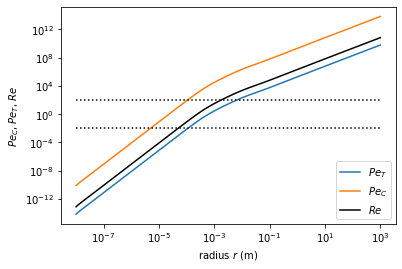

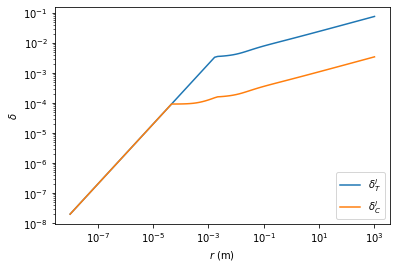

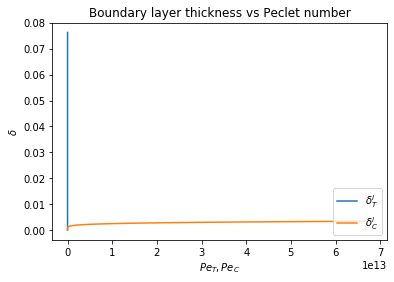

In [7]:
# Plot the BLs and Re, etc
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r, PeT, label="$Pe_T$")
ax.plot(r, PeC, label="$Pe_C$")
ax.plot(r, PeC*Dliq/mu, label="$Re$", color="black")
ax.plot(r, 1e-2*np.ones(len(r)), color="black", linestyle=':') #Mark the intermediate regime in Inman et al
ax.plot(r, 1e2 *np.ones(len(r)), color="black", linestyle=':')
ax.set_xlabel('radius $r$ (m)')
ax.set_ylabel('$Pe_C$, $Pe_T$, $Re$')
ax.legend(loc=4)
file2="Pe.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r, deltaT, label="$\delta_T^l$")
ax.plot(r, deltaC, label="$\delta_C^l$")
ax.set_xlabel('$r$ (m)')
ax.set_ylabel('$\delta$')
ax.legend(loc=4)
file2="BL.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

fig, ax = plt.subplots()
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(PeT, deltaT, label='$\delta_T^l$')
ax.plot(PeC, deltaC, label='$\delta_C^l$')
ax.set_xlabel('$Pe_T,Pe_C$')
ax.set_ylabel('$\delta$')
ax.set_title('Boundary layer thickness vs Peclet number')
ax.legend(loc=4)

# Phase equilibrium

If we are going to worry about phase equilibrium we need to know how much solid
and how much liquid we expect at a given temperature, pressure and composition.
As discussed in a seperate notebook, there are two ways to do this calculation.
For the sake of simplicity (and because I don't have a ready to use parameterisation
of the free energy of the solid and liquid phase ready to use) we'll use an 
"experimental" extrapolated phase diagram for now and apply the lever rule.

For this notebook, we'll use the 330 GPa Fe-FeO phase diagram of Komabayashi 
(2014; http://dx.doi.org/10.1002/2014JB010980) with the key parameters given
by the following:

* Pure Fe melting temperature: $\sim$6400 K
* Eutectic temperature: $\sim$4400 K
* Eutectic composition: $\sim$9 wt.% O
* FeO melting temperature: $\sim$6000 K
* Both solid FeO and Fe are phase pure (no O in Fe, $\sim$ 23 wt.% O in FeO.
* Liquidus above and below the eutectic is a straight line.

and for now we'll also assume that we don't care about O compositions beyond
the eutectic (but this would be easy to add). The phase diagram is implemented
below.

A brief note on perfomance. I've compiled this using Numba so that the code can
will run quickly and provided NumPy ufuncs to allow graphs to be made with many
points.

Once we know what the equilibrium volume fraction is, we can see how long it
takes to reach this with kinetic limitations on solid growth or nucleation.

In [8]:
@numba.jit(nopython=True)
def phase_relations_komabayashi2004(t, x):
    """
    Returns the phase proportions and compositions for Fe-FeO
    
    This is a simple implementation of the 330 GPa binary phase
    diagram from Figure 6 of Komabayashi (2014) assuming the
    liquidus is a straight line, and Fe and FeO are solid. For
    a given temperature (t, in Kelvin) and bulk composition (x, mass
    fraction oxygen), the function will return the mass fraction liquid
    (phi_lq), the mass fraction Fe (phi_fe), the mass fraction FeO 
    (phi_feo), and the liquid composition (as a mass fraction, x_lq).
    
    This version only works for x < eutectic
    """
    fe_melt = 6400.0
    eutectic_t = 4400.0
    eutectic_x = 0.09 # Wt frac, 9 wt%

    # Check input... x > 0 and < 1, t positive etc.
    assert (t > 0), "Temperature must be positive"
    assert ((x >= 0.0) and (x <= eutectic_x)), "Wt fraction must be between 0 and eutectic"
    
    # liquidus_grad = dc/dTl
    # liquidus_int  = 
    
    liquidus_grad = eutectic_x / (eutectic_t-fe_melt) # wt frac / K
    liquidus_int = eutectic_x - liquidus_grad * eutectic_t  
    x_liquidus = liquidus_grad * t + liquidus_int
    t_liquidus = fe_melt + x * (eutectic_t - fe_melt) / (eutectic_x)
    if t <= eutectic_t:
        # Just solid...
        x_fe = 0.0
        x_lq = np.nan
        x_feo = 0.22270
        phi_fe = (x - x_feo) / (x_fe - x_feo)
        phi_feo = 1.0 - phi_fe
        phi_lq = 0.0
    elif x >= x_liquidus:
        # RHS of liquidus, just liquid
        x_fe = 0.0
        x_lq = x
        x_feo = 0.0
        phi_fe = 0.0
        phi_lq = 1.0
        phi_feo = 0.0
    else:
        # Must be two phase. Lever rule
        x_fe = 0.0
        x_lq = x_liquidus
        x_feo = 0.0
        phi_fe = (x - x_lq) / (x_fe - x_lq)
        phi_lq = 1.0 - phi_fe
        phi_feo = 0.0
    
    return(x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus, t_liquidus)

@numba.vectorize([numba.float64(numba.float64, numba.float64)],
                nopython=True)
def total_solid_fraction(t,x):
    "Just a helper wrapper (for making graph)"
    x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus, t_liquidus = \
    phase_relations_komabayashi2004(t,x)
    return(phi_fe+phi_feo)

@numba.vectorize([numba.float64(numba.float64, numba.float64)],
                nopython=True)
def liquid_o_wt_fraction(t,x):
    "Just a helper wrapper (for making graph)"
    x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus, t_liquidus = \
    phase_relations_komabayashi2004(t,x)
    return(x_lq)

def volume_fraction_solid(phi_fe, phi_lq, x_lq):
    """
    Convert from weight fraction Fe to volume fraction Fe
    
    Just work out the volume of a kg of stuff, then
    return the volume fraction that is sold. We need 
    to know the density of Fe and the density of an FeO
    melt. The latter comes from Figure 7d of Komabayashi
    (2014) - so is at 330 GPa and 5000 K. Assume that this
    does not change much with P or T. We also need the density
    of pure liquid Fe (which comes from table IV of Alfe; 2002)
    and pure solid Fe (where we assume a fraction change in
    volume on melting of 0.02, see Figure 2 of the same paper).
    """
    density_pure_fe_melt = 12844 + 30*((13315-12844)/50) # kg/m^3
    density_pure_fe_solid = density_pure_fe_melt * 1.02 # kg/m^3
    density_melt = (1.0+(x_lq*(-0.825/0.22270))) * density_pure_fe_melt # Fig 7d
    volume_melt = phi_lq / density_melt
    volume_fe_solid = phi_fe / density_pure_fe_solid
    vol_frac_solid = volume_fe_solid / (volume_fe_solid + volume_melt)
    return vol_frac_solid

We can use the code above in a couple of ways. First, we can 
calculate the fraction of phases (and their compositions) at
some temperature and bulk composition:

In [9]:
t = 5500
x = 0.03
x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus, t_liquidus = \
        phase_relations_komabayashi2004(t, x)
print("Temperature:", t, "K, bulk O wt. frac:", x)
print("Weight frac solid Fe: {:4.3f}".format(phi_fe))
print("Weight frac solid FeO: {:4.3f}".format(phi_feo))
print("Weight frac liquid: {:4.3f}".format(phi_lq))
print("O wt. frac in liquid: {:4.3f}".format(x_lq))
print("T liquidus: {:4.3f}".format(t_liquidus))
print("Volume frac solid Fe {:4.3f}".format(
        volume_fraction_solid(phi_fe, phi_lq, x_lq)))
print()

Temperature: 5500 K, bulk O wt. frac: 0.03
Weight frac solid Fe: 0.259
Weight frac solid FeO: 0.000
Weight frac liquid: 0.741
O wt. frac in liquid: 0.041
T liquidus: 5733.333
Volume frac solid Fe 0.226



or we can plot the phase diagram in several ways (these plots do need to be improved):

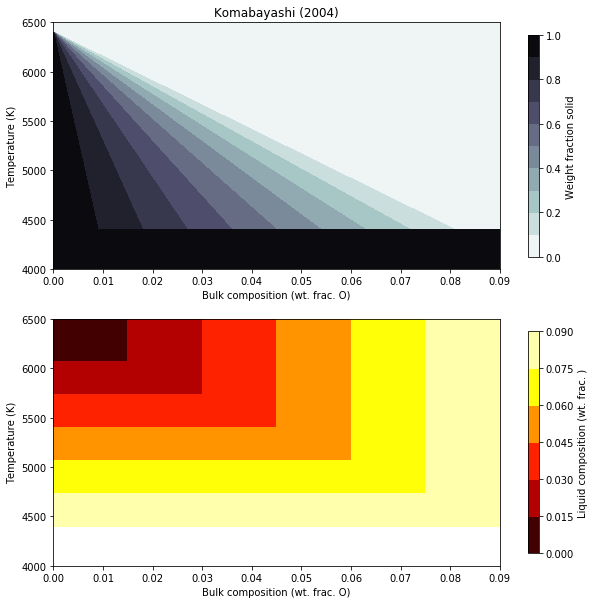

In [10]:
# Grid of points to calculate weight fraction
temps, xs = np.meshgrid(np.linspace(4000, 6500, 2200),
                     np.linspace(0.0, 0.09, 500))

# Total weight fraction solid
frac_solid_fe = total_solid_fraction(temps, xs)
x_lq = liquid_o_wt_fraction(temps, xs) 

# Graph the result
fig, ax = plt.subplots(nrows=2, figsize=(10,10))
h = ax[0].contourf(xs, temps, frac_solid_fe, 
                   cmap=plt.cm.bone_r,
                   levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar = fig.colorbar(h, ax=ax[0], shrink=0.9)
ax[0].set_title("Komabayashi (2004)")
cbar.ax.set_ylabel("Weight fraction solid")
ax[0].set_ylabel("Temperature (K)")
ax[0].set_xlabel("Bulk composition (wt. frac. O)")

h = ax[1].contourf(xs, temps, x_lq, 
                   cmap=plt.cm.hot)
cbar = fig.colorbar(h, ax=ax[1], shrink=0.9)
cbar.ax.set_ylabel("Liquid composition (wt. frac. )")
ax[1].set_ylabel("Temperature (K)")
ax[1].set_xlabel("Bulk composition (wt. frac. O)")

plt.savefig("komabayashi.pdf", format='pdf',bbox_inches="tight")
plt.show()

# Crystal growth following Sun et al. (2018)

The Kirkpatrick growth models assume that the process of crystal growth at an interface can be described
in terms of a diffusional equation and treated as if this was solving a bulk diffusion problem (i.e. that
the Stokes-Einstien equation holds). This seems unlikly. Fortunatly, more recent work has 
attempted to quantify and understand crystal growth in metals using atomic scale simulation. Importantly,
this is a very quick process.

Here we follow Sun et al. (2018; Nature Materials 17:881-886, https://doi.org/10.1038/s41563-018-0174-6)
who simulate crystal growth of the FCC metals Al, Ni, Cu, Ag, Pt and Pb using an embedded atom model at
temperatures from the (simulated) melting point down to undercoolings of ~300 K below the melting point in order
to understand why crystal growth for these crystals was "ultrafast". These calculations were undertaken
using LAMMPS and were not at elevated pressure. These atomic scale results were compared with three models
and an emprical fit:

1. A linear fit of growth rate againts undercooling
2. The Wilson–Frenkel model, where growth is limited by diffusion in the liquid
3. A Ginzburg–Landau approach, where growth is contolled by density fluctuations in the liquid
4. A collision rate model

All these models can be described the interaction of a kinetic and a thermodynamic term (equation 1 of Sun; S1):

$$ V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right],$$

where $V(T)$ is the growth rate of the crystal (normal to the 111 face) $k(T)$ is a kinetic function and
$\Delta\mu$ is the difference in the chemical potential of the solid and theliquid. This is analogous to K4,
(or K8). $k(T)$ is different for the different models:

1. $k(T) = k_0$
2. $k(T) = l\frac{6D(T)}{\gamma^2}$
3. $k(T) \propto \frac{S(K_i)}{\tau(K_i)}$
3. $k(T) \propto \sqrt{\frac{3K_B T}{M}}$

Models 1 and 4 reproduce the atomic scale data fairly well over the temperature range (see Sun et al. Fig 1).

For simplicity, I'll take model 1 and write a growth rate function.

Sun SI: https://static-content.springer.com/esm/art%3A10.1038%2Fs41563-018-0174-6/MediaObjects/41563_2018_174_MOESM1_ESM.pdf

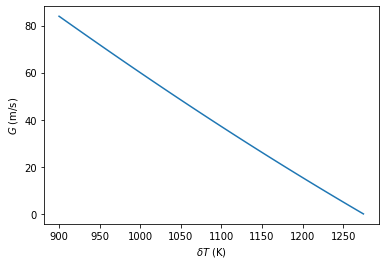

In [11]:
# Data for Cu (because I have a EAM set up in LAMMPS for Cu in case we want to take it further)

cu_k0 = 212 # [K^-1]? Table 2
cu_tm = 1275 # [K] Table 1
cu_dhm = 1.21 * kb * cu_tm # [J] SI table S1, heat of fusion at melting point

cu_mass = 1.055e-25
cu_k04  =np.sqrt(3.0*kb*cu_tm/cu_mass)

def sun_velocity_fit(dt, tm, dhm, k0):
    """
    dT is the undercooling
    Tm is the melting temperature
    dmu is the difference in chemical potentials
    k0 is a rate constant
    r is the particle radius
    """
    t = tm - dt
    d_mu = (tm - t) * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    v = k0 * (1.0 - np.exp(-d_mu/(kB * t)))
    return v

# Plot graph - like Fig 1 of paper
fig, ax = plt.subplots()
ts_ = np.linspace(900, cu_tm)
dts = cu_tm - ts_
vs  = sun_velocity_fit(dts, cu_tm, cu_dhm, cu_k0)
ax.plot(ts_, vs)
#ax.plot(dts, vs)
ax.set_xlabel('$\delta T$ (K)')
ax.set_ylabel('$G$ (m/s)')
#ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
file2="Sun.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

## Nucleation timescale

Uses eqn 6 of https://www.sciencedirect.com/science/article/pii/S0012821X18306782

In [12]:
def tauv(dT, Tm):
    """
    hf    = enthalpy of fusion
    gamma = surface tension
    hc    = enthalpy correction - see DPA19, below eqn 2
    """
    hf    = 0.976e10
    gamma = 1.05
    prefac= 5.366215575895298e-46   # Other way up to Huguet
    
    hc   = 1.0 - 7.046e-5*dT
    T_Fe = dT + Tm
    num  = 16 * np.pi * Tm**2 * gamma**3
    den  = 3  * kb * hf**2 * hc**2 * T_Fe * dT**2
    fac  = num/den
    return prefac * np.exp(fac) 

In [13]:
def tau_phase_TO(rad, T_abs, O_abs):
    
    """Calculate the phase equilibrium timescale tau_P = N*tau_N + tau_G
    as a function of absolute temperature T_abs and O concentration O_conc. 
    Assume a radius rad to get number of particles N from the equilibrium 
    volume fraction v_f. The total volume of solid V_f = v_f * Vsl, the 
    slurry volume. """

    tN      = np.zeros([len(T_abs), len(O_abs)])
    tG      = np.zeros([len(T_abs), len(O_abs)])
    ttot_TO = np.zeros([len(T_abs), len(O_abs)])

    time = 0 
    for t in T_abs:
        oo = 0
        for o in O_abs: 
            x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus,t_liquidus = \
            phase_relations_komabayashi2004(t, o)
            v_f = volume_fraction_solid(phi_fe, phi_lq, x_lq) # eq sol vol @ this T & c
        
            dT  = t - t_liquidus 
        
            if dT > 0: continue
        
            V_f = v_f * Vsl                                   # total solid volume
            N   = 3 * V_f / (4 * np.pi * rad**3) 
        
            tN[time,oo] = N * tauv(dT, t_liquidus) / Vsl / secinyr
            G           = sun_velocity_fit(-dT, t_liquidus, cu_dhm, cu_k0) # CHK dT DEF POSITIVE!
            tG[time,oo] = rad/G/secinyr
        
            ttot_TO[time,oo] = tN[time,oo] + tG[time,oo]
                
            oo = oo + 1
        time = time + 1
    return ttot_TO, tN, tG

T_abs   = np.linspace(4500, 6500, 11)
O_abs   = np.linspace(0.01, 0.08, 11)
tN      = np.zeros([len(T_abs), len(O_abs)])
tG      = np.zeros([len(T_abs), len(O_abs)])
ttot_TO = np.zeros([len(T_abs), len(O_abs)])

rad   = 1e-6

ttot_To,tN, tG = tau_phase_TO(rad, T_abs, O_abs)

C:\Users\Peter Davies\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [15]:
def tau_phase_r(Temp, Oconc): 
    
    """Calculate the phase equilibrium timescale tau_P = N*tau_N + tau_G
    as a function of radius r. 
    Assume a radius rad to get number of particles N from the equilibrium 
    volume fraction v_f. The total volume of solid V_f = v_f * Vsl, the 
    slurry volume. """
    
    ttot_r = np.zeros(len(r))
    rr     = 0
    for rad in r:
        x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus,t_liquidus = \
        phase_relations_komabayashi2004(Temp, Oconc)
        v_f = volume_fraction_solid(phi_fe, phi_lq, x_lq) # eq sol vol @ this T & c
        
        dT  = Temp - t_liquidus 
        
        if dT > 0: continue
        
        V_f = v_f * Vsl                                   # total solid volume
        N   = 3 * V_f / (4 * np.pi * rad**3) 
        
        tN_r = N * tauv(dT, t_liquidus) / Vsl / secinyr
        G_r  = sun_velocity_fit(-dT, t_liquidus, cu_dhm, cu_k0) # CHK dT DEF POSITIVE!
        tG_r = rad/G_r/secinyr
    
        ttot_r[rr] = tN_r + tG_r
                
        rr = rr + 1
        
    return ttot_r

Temp = [5150,5250, 5150, 5250]
Oconc= [0.01, 0.01, 0.02, 0.02]
ttot_r = []
for i, o in zip(Temp, Oconc):
    ttot_r.append(tau_phase_r(i, o))

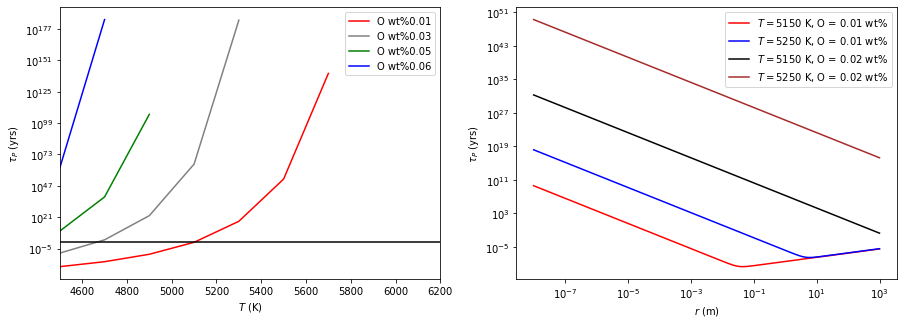

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_yscale('log')
ax1.set_xlabel('$T$ (K)')
ax1.set_ylabel('$\\tau_P$ (yrs)')
ax1.set_xlim([4500,6200])
ax1.plot(T_abs, tN[:,0]  , color='red'   ,label="O wt%"+str(np.round(O_abs[0],2)))
ax1.plot(T_abs, tN[:,3]  , color='grey',label="O wt%"+str(np.round(O_abs[3],2)))
ax1.plot(T_abs, tN[:,5]  , color='green' ,label="O wt%"+str(np.round(O_abs[5],2)))
ax1.plot(T_abs, tN[:,7]  , color='blue'  ,label="O wt%"+str(np.round(O_abs[7],2)))
ax1.plot(T_abs, ttot_TO[:,0], color='red'   , ls=':')
ax1.plot(T_abs, ttot_TO[:,3], color='grey', ls=':')
ax1.plot(T_abs, ttot_TO[:,5], color='green' , ls=':')
ax1.plot(T_abs, ttot_TO[:,7], color='blue'  , ls=':')
ax1.plot(T_abs, np.ones(len(T_abs)), color="black")
ax1.legend()

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$r$ (m)')
ax2.set_ylabel('$\\tau_P$ (yrs)')
ax2.plot(r, ttot_r[0]  , color='red'  , label="$T=5150$ K, O = 0.01 wt%")
ax2.plot(r, ttot_r[1]  , color='blue' , label="$T=5250$ K, O = 0.01 wt%")
ax2.plot(r, ttot_r[2]  , color='black', label="$T=5150$ K, O = 0.02 wt%")
ax2.plot(r, ttot_r[3]  , color='brown', label="$T=5250$ K, O = 0.02 wt%")
ax2.legend()
file2="Tp.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

In [19]:
NT = 11
dT = np.linspace(400,900,NT)

tnuc  = np.zeros(len(dT))
tIsun = np.zeros([len(r), len(dT)])

ii = 0
for i in dT:
    tnuc[ii] = tauv(i, Tm) / Vsl / secinyr
    
    jj = 0 
    for j in r:
        G = sun_velocity_fit(i, Tm, cu_dhm, cu_k0)
        tIsun[jj,ii] = j/G/secinyr
        jj = jj + 1
    ii = ii + 1

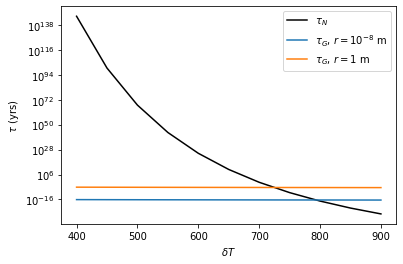

In [20]:
#Plot nucleation and growth rates as functions on dT
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(dT, tnuc       , label='$\\tau_N$'              , color='black')
ax.plot(dT, tIsun[0,:] , label='$\\tau_G$, $r=10^{-8}$ m')
ax.plot(dT, tIsun[99,:], label='$\\tau_G$, $r=1$ m')
ax.set_xlabel('$\delta T$')
ax.set_ylabel('$\\tau$ (yrs)')
ax.legend(loc=1)
file2="TgTn.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

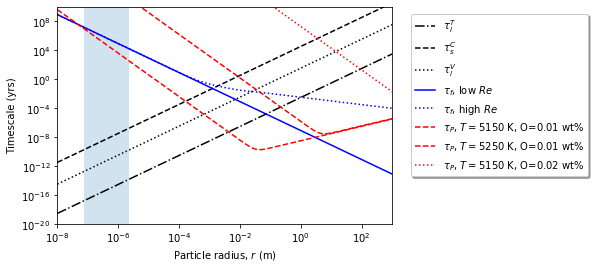

In [23]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
plt.xlabel("Particle radius, $r$ (m)")
plt.ylabel("Timescale (yrs)")
plt.xlim([1e-8 ,1e3])
plt.ylim([1e-20,1e10])
plt.loglog(r, tt , color="black", linestyle="dashdot", label="$\\tau_l^T$")
plt.loglog(r, ts , color="black", linestyle="--"     , label="$\\tau_s^C$")
plt.loglog(r, tl , color="black", linestyle=":"      , label="$\\tau_l^V$")
plt.loglog(r, tVl, color="blue" , linestyle="-"      , label="$\\tau_f$, low $Re$")
plt.loglog(r, tVh, color="blue" , linestyle=":"      , label="$\\tau_f$, high $Re$")
plt.loglog(r, ttot_r[0], color="red" , linestyle="--"   , label="$\\tau_P$, $T = 5150$ K, O=0.01 wt%")
plt.loglog(r, ttot_r[1], color="red" , linestyle="--"   , label="$\\tau_P$, $T = 5250$ K, O=0.01 wt%")
plt.loglog(r, ttot_r[2], color="red" , linestyle=":"    , label="$\\tau_P$, $T = 5150$ K, O=0.02 wt%")
#plt.loglog(r, tIsun[:,0] , color="red" , linestyle="--"   , label="$\\tau_G$, $\delta T = 400$ K")
#plt.loglog(r, tIsun[:,9] , color="red" , linestyle="--"   , label="$\\tau_G$, $\delta T = 900$ K")
#plt.loglog(r, tnuc[6]*np.ones(len(r)) , color="red" , linestyle=":", label="$\\tau_N$, $\delta T = 700$ K")
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
          fancybox=True, shadow=True)

# Create a Rectangle patch
rect = patches.Rectangle((7.406621140274367e-08, 1e-21), (2.3421789543362724e-06-7.406621140274367e-08), 1e20, alpha=0.2)
ax.add_patch(rect)
file2="Regime1.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

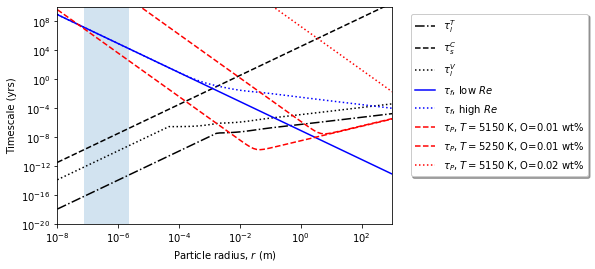

In [24]:
# Now using BL estimates for the liquid

fig, ax = plt.subplots()
plt.xlabel("Particle radius, $r$ (m)")
plt.ylabel("Timescale (yrs)")
plt.xlim([1e-8 ,1e3])
plt.ylim([1e-20,1e10])
plt.loglog(r, tt_liq , color="black", linestyle="dashdot", label="$\\tau_l^T$")
plt.loglog(r, ts , color="black", linestyle="--"     , label="$\\tau_s^C$")
plt.loglog(r, tl_liq , color="black", linestyle=":"      , label="$\\tau_l^V$")
plt.loglog(r, tVl, color="blue" , linestyle="-"      , label="$\\tau_f$, low $Re$")
plt.loglog(r, tVh, color="blue" , linestyle=":"      , label="$\\tau_f$, high $Re$")
plt.loglog(r, ttot_r[0], color="red" , linestyle="--"   , label="$\\tau_P$, $T = 5150$ K, O=0.01 wt%")
plt.loglog(r, ttot_r[1], color="red" , linestyle="--"   , label="$\\tau_P$, $T = 5250$ K, O=0.01 wt%")
plt.loglog(r, ttot_r[2], color="red" , linestyle=":"    , label="$\\tau_P$, $T = 5150$ K, O=0.02 wt%")
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
          fancybox=True, shadow=True)

rect = patches.Rectangle((7.406621140274367e-08, 1e-21), (2.3421789543362724e-06-7.406621140274367e-08), 1e20, alpha=0.2)
ax.add_patch(rect)
file2="Regime2.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

## Conclusions from these graphs: 
We are assuming that the particles remain the same radius as they fall through the F-layer. 

We also assume that the system has overcome the initial homogeneous nucleation barrier. 

1. If solid diffusion is relevant it is always the limiting process.
2. If solid diffusion is not relevant and the BL plot is relevant then the system is basically always in phase equilibrium.
3. If the particle radius changes as it moves through the F-layer this will not change the fact that solid diffusion is slower than liquid or thermal diffusion. 

The next cell implements the following equations to calculate the number and size of particles falling out of the F-layer at the Stokes velocity. 

$$ V_E = \frac{4 \pi r^3 N}{3} , \quad 4\pi r^3 N P V_s = 4\pi r_i^2 \frac{d r_i}{dt}, \quad V_S = \frac{2}{9} \frac{\Delta \rho g r^2}{\mu} $$

$$ r^5 N P \frac{2}{9} \frac{\Delta \rho}{\mu} = r_i^2 \frac{d r_i}{dt} $$
$$ r^2 = \frac{4 \pi r^5 N}{3 V_e}$$

We use the Zhang formulation to calculate $V_s$ and therefore guess at the particle radius $r$ in order to estimate $N$. I use brentq to converge to a solution. 

In [26]:
def meanPsize_closure():
    
    params = {}

    def meanPsize(t_snow, dridt, ri,mu, Vfrac):
        """
        Evaluate the mean size and number of particles in the snowing layer
        
        t_snow: thickness of the snowing layer (in m)
        dridt: chage in ICB radius with time (m/s)
        ri: ICB radius (in m)
        mu: kinematic viscosity
        Vfrac: volume fraction of solid
        """
        assert t_snow > 0, "Snowing layer must have positive thickness"
        rtop    = ri + t_snow
        Vflayer = 4.0 * np.pi * (rtop**3 - ri**3) / 3.0 
        Ve    = Vfrac * Vflayer 
        Pack  = 0.67
        r5N   = 9.0 * (mu * ri**2 * dridt) / (2.0 * drho * g * Pack) 
        r2    = 4 * np.pi * r5N / (3.0*Ve)
        r     = np.sqrt(r2)
        N     = 3.0 * Ve / (4.0 * np.pi * r**3) 
        Vs    = (2.0/9.0) * drho * g * r2 / (mu)
        t     = (rtop-ri)/Vs
            
        if Ve < 0:
            t = -1.0
                  
        params['r']  = r
        params['N']  = N
        params['Vs'] = Vs
        params['Ve'] = Ve
        params['t']  = t
        params['rf'] = t_snow   
    
        return t-secinyr
    
    return params, meanPsize


# Work out a volume fraction solid
t = 5500 # K
x = 0.04 # wt frac O

x_fe, x_lq, x_feo, phi_fe, phi_lq, phi_feo, x_liquidus, t_liquidus = \
        phase_relations_komabayashi2004(t, x)
print("Temperature:", t, "K, bulk O wt. frac:", x)
print("Weight frac solid Fe: {:4.3f}".format(phi_fe))
print("Weight frac solid FeO: {:4.3f}".format(phi_feo))
print("Weight frac liquid: {:4.3f}".format(phi_lq))
print("O wt. frac in liquid: {:4.3f}".format(x_lq))

Vfrac = volume_fraction_solid(phi_fe, phi_lq, x_lq)
print("Volume frac solid Fe {:4.3f}\n".format(Vfrac))


# Work out particle number and size...
dridt   = 1e-3 / secinyr
mu_test = 1e-6 * rhol

params, meanPsize = meanPsize_closure()
optimize.brentq(meanPsize, 0.001, 1e3, args=(dridt, ri, mu_test, Vfrac))

print('layer thickness = ', params['rf'], 'm')
print('Ve    = ', params['Ve'])
print('Vs    = ', params['Vs'], ' m/s')
print('dridt = ', dridt, ' m/s')
print('t     = ', params['t']/secinyr, ' yrs')
print('r, N = ', params['r'], params['N'])

Temperature: 5500 K, bulk O wt. frac: 0.04
Weight frac solid Fe: 0.012
Weight frac solid FeO: 0.000
Weight frac liquid: 0.988
O wt. frac in liquid: 0.041
Volume frac solid Fe 0.010

layer thickness =  0.21968293108607237 m
Ve    =  42427634648.7258
Vs    =  6.966100041297478e-09  m/s
dridt =  3.1709791983764586e-11  m/s
t     =  1.00000000136185  yrs
r, N =  4.1334939698259793e-07 1.4341952702715658e+29


In [ ]:
# Loop over a range of viscosities and IC growth rates

dridt = np.logspace(-4, -2, 10)/secinyr
muA   = np.logspace(-7, -5, 10)
nuA   = muA * rhol

Nv    = np.zeros((len(dridt),len(nuA))) # v denotes vector here
rv    = np.zeros((len(dridt),len(nuA)))
Vev   = np.zeros((len(dridt),len(nuA)))
Vsv   = np.zeros((len(dridt),len(nuA)))
rfv   = np.zeros((len(dridt),len(nuA)))

ii = 0
for i in dridt:
    jj = 0
    for j in nuA:
        optimize.brentq(meanPsize, 1e-8, 1e4, args=(i, ri, j, Vfrac))
        Nv[ii,jj]  = params['N']
        rv[ii,jj]  = params['r']
        Vev[ii,jj] = params['Ve']
        Vsv[ii,jj] = params['Vs']
        rfv[ii,jj] = params['rf']        
                
        jj = jj + 1
        
    ii = ii + 1
    
print('Rmax = ', np.max(rv), ' Rmin = ', np.min(rv))

In [ ]:
# Plot results
fig, ax = plt.subplots()
ax.set_xlabel("$r_f$ (m)")
ax.set_ylabel("$r$ (m)")
ax.set_yscale('log')
ax.plot(rfv[:,0], rv[:,0], color="black" , linestyle="--",label="$\\mu = $"+str(nuA[0]))
ax.plot(rfv[:,5], rv[:,5], color="red"   , linestyle="-" ,label="$\\mu = $"+str(nuA[5]))
ax.plot(rfv[:,9], rv[:,9], color="orange", linestyle=":" ,label="$\\mu = $"+str(nuA[9]))
#ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
#          fancybox=True, shadow=True)
file2="Vf.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$dr_i/dt$ (mm/yr)")
ax.set_ylabel("$r$ (m)")
ax.plot(dridt*secinyr*1000, rv[:,0], color="black" , linestyle="--",label="$\\mu = $"+str(nuA[0]))
ax.plot(dridt*secinyr*1000, rv[:,5], color="red"   , linestyle="-" ,label="$\\mu = $"+str(nuA[5]))
ax.plot(dridt*secinyr*1000, rv[:,9], color="orange", linestyle=":" ,label="$\\mu = $"+str(nuA[9]))
ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
          fancybox=True, shadow=True)


fig, ax = plt.subplots()
ax.set_xlabel("$N$")
ax.set_ylabel("$r$ (m)")
ax.loglog(Nv[:,0], rv[:,0], color="black" , linestyle="--",label="$\\mu = $"+str(nuA[0]))
ax.loglog(Nv[:,5], rv[:,5], color="red"   , linestyle="-" ,label="$\\mu = $"+str(nuA[5]))
ax.loglog(Nv[:,9], rv[:,9], color="orange", linestyle=":" ,label="$\\mu = $"+str(nuA[9]))
ax.legend(loc=1)
file2="rN.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

## Particle size and Growth estimates from Marsh 1998 ##

In Marsh the total number of particles is

$$ N_0 = C_N \left(  \frac{J_0}{G_0} \right)^{3/4} ,$$

where $J_0$ (m$^{-3}$ s$^{-1}$) and $G_0$ (m~s$^{-1}$) are the characteristic rates of nucleation and growth. The typical crystal size is

$$ L_0 = C_L \left(  \frac{G_0}{J_0} \right)^{1/4} .$$

Marsh's Table 1 gives $0.8 < C_N < 61$ and $0.1 < C_L <0.7$. As a first pass we can take these values. 

Marsh defined $J_0$ and $G_0$ such that

$$J(t) = J_0 \exp\left({\frac{at}{t_c}}\right), \quad G(t) = G_0 \exp\left({\frac{bt}{t_c}}\right)$$

Marsh 1988 also gives analytical solutions for the CSD $n$ in simple situations. I consider the case where the volume $V$ of the system is constant and the system is "flushed" on a (constant) timescale $\tau_s$ (the Stokes timescale). In this case the solution is 

$$ n = \frac{J_0}{G_0} \exp{(-L/G_0\tau)} .$$

In [ ]:
import scipy.integrate

NT  = 11
G0  = np.zeros(NT)
J0  = np.zeros(NT)
intn= np.zeros([NT,len(r)])
nn  = np.zeros([NT,len(r)])
nn2 = np.zeros([NT,len(r)])
dT  = np.linspace(500,900,NT)
G1  = 1e-2

kk = 0
for k in dT:
    G0[kk] = sun_velocity_fit(k, Tm, cu_dhm, cu_k0)
    J0[kk] = 1.0/tauv(k, Tm)
    
    n0 = J0[kk]/G0[kk]
    ii = 0
    for i in r:
        nn[kk,ii]  = n0 * np.exp(-i/(G0[kk]*tVh[ii]*secinyr)) 
        nn2[kk,ii] = n0 * np.exp(-i/(G1    *tVh[ii]*secinyr)) 
        ii  = ii + 1
        
    intn[kk,:] = scipy.integrate.cumtrapz(nn[kk,:],r,initial=0)
        
    kk = kk + 1

In [ ]:
tmp = 1e30*np.ones(len(dT))
tmp2= 1e-7*np.ones(len(dT))

fig, ax = plt.subplots()
ax.set_xlabel("$r$")
ax.set_ylabel("$n$")
ax.set_ylim([1e-20,1e-2])
ax.loglog(r, nn[7,:], color="black", linestyle="--",label="$\\tau_N$ for $\delta T = $"+str(dT[7]))
ax.loglog(r, nn[8,:], color="red"  , linestyle="--",label="$\\tau_N$ for $\delta T = $"+str(dT[8]))
ax.loglog(r, nn[9,:], color="blue" , linestyle="--",label="$\\tau_N$ for $\delta T = $"+str(dT[9]))
ax.loglog(r, nn2[7,:], color="black", linestyle="-")
ax.loglog(r, nn2[8,:], color="red"  , linestyle="-")
ax.loglog(r, nn2[9,:], color="blue" , linestyle="-")
ax.legend(loc='lower left', bbox_to_anchor=(0.01, 0.01),
          fancybox=True, shadow=True)
file2="CSD.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

# Growth rate based on chemical diffusion
G0c = Dsol/1e-6
tmp3 = np.ones(len(dT))

fig, ax = plt.subplots()
ax.set_xlabel("$dT$")
ax.set_ylabel("$N$")
ax.set_yscale('log')
ax.set_xlim([500,900])
ax.set_ylim([1e-25,1e5])
ax.plot(dT, (J0/G0)**0.75 , color="purple" , linestyle="--",label="$N_0$ using $\\tau_G$")
ax.plot(dT, (J0/G0c)**0.75, color="red"    , linestyle="--",label="$N_0$ using $\\tau_s^C$")
ax.plot(dT, intn[:,-1]    , color="orange" , linestyle="--",label="$N_0 = \int n dr$")
ax.plot(dT,tmp3,color="black") 
ax.legend(loc=4)
file2="N0.pdf"
plt.savefig(file2, format='pdf',bbox_inches="tight")

## Calculation of a single particle that starts at the top of the layer and grows as it falls ##

The location $l_p$ of a particle changes according to the Stokes equation: 

$$ \frac{d l_p}{d t } = \frac{2}{9} \frac{\Delta \rho g r^2}{\mu} .$$

At time $t^j$ the particle has radius $r_j$. At the next time $t^{j+1}$ the new location is 

$$ l_p^{j+1} = l_j^i - \frac{2}{9} \frac{\Delta \rho g r_j^2}{\mu}\Delta t ,$$

where the minus sign indicates a downward velocity. To update the size of the particle I use the growth rate $G$ such that 

$$ r_{j+1} = r_j + G(T)\Delta t .$$

**But...** G should also decrease as we approach phase equilibrium. So for 5500 K and
4wt% O growth should stop at a volume fraction solid of 0.01. Do we do this by playing
with the chemical potential? Not sure... need to think further about this calculation!


In [ ]:
# Set equally spaced times
tp  = secinyr*np.linspace(1,10,200)
dt  = tp[1] - tp[0]   

# Start a small particle at the top of the F-layer
rp = 1e-9*np.ones(len(tp))
lp = rf  *np.ones(len(tp))

print('dt, particle location, particle radius, Vs,  Change in part loc')

ii = 1
for i in tp:
    Vs  = optimize.brentq(fzhang_opt, -1.0, 100.0, args=(rp[ii-1]))
    G   = sun_velocity_fit(200, 5500.0, cu_dhm, cu_k0)
    G   = 1e-10

    rp[ii] = rp[ii-1] + G*dt
    lp[ii] = lp[ii-1] - Vs*dt
    
    if lp[ii] < ri:
        break 
    
    print(np.round(dt/secinyr,3), np.round(lp[ii]/1e3,2), np.round(rp[ii],5), np.round(Vs,5), np.round(Vs*dt/1e3,5))
    
    ii = ii + 1

print("Particle has left the layer!")

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("$t$ (yrs)")
ax.set_ylabel("Particle location, $l_p$ (km)")
ax.set_xlim([1,2])
ax.plot(tp/secinyr, lp/1e3, color="purple" , linestyle="--",label="")
ax.legend(loc=4)

fig, ax = plt.subplots()
ax.set_xlabel("$t$ (yrs)")
ax.set_ylabel("Particle radius, $r_p$ (m)")
ax.set_xlim([1,2])
ax.plot(tp/secinyr, rp, color="purple" , linestyle="--",label="")
ax.legend(loc=4)


#file2="tdep.pdf"
#plt.savefig(file2, format='pdf',bbox_inches="tight")

## OLD STUFF BELOW##

## Interface timescale. 

Here I implement equation 17 of Kirkpatrick (1974), "Kirkpatrick, R.J., 1975. Crystal growth from the melt: a review. American Mineralogist: Journal of Earth and Planetary Materials, 60(9-10), pp.798-814.". Below I refer to his equations as KX. 

- I assume that the growth rate is $da/dt$ where $a$ is particle radius
- Then time is $a/(da/dt)$
- I interpret this as the timescale required to grow the crystal to size a assuming that there are no diffusive hiderances to the process; the only obstacle seems to be the random detachment of particles from the surface according to K4.

- I take $f=1$
- Dario validates that K13 is a pretty good approximation; I have not included the correction in our eqn 2 here. 

The aassumption in K16 is checked in the cell kirk_growth17: it seems to be a bad approximation. Therefore we use eqn 14 in cell kirk_growth14. 

**However**

This model was found to be unsuitable because of the assumption that the rate constant can be described by a diffusion process (see eqn 9, which follows Turnbull and Cohen, 1960). It was replaced by the Sun et al study above. 

In [ ]:
# Implement growth model of Kirkpatrick eqn 14, which does not invoke approximation K16
# Hc is latent heat
# Tl is liquidus
# eta is dynamic viscosity in Pa.s
def kirk_growth14(dT,Tl,eta,r):
    T = Tl - dT
    kB = 1.380649e-23 #J/K
    Rg = 8.314462
    f  = 1
    hf = 0.976e10
    Y  = (f*kB*T) / (3.0*np.pi*r**2*eta) * ( 1.0-np.exp( -(hf * dT)/(Rg*T*Tl) ) )
    return Y

In [ ]:
# Implement growth model of Kirkpatrick eqn 17
# Hc is latent heat
# Tl is liquidus
# eta is dynamic viscosity in Pa.s
def kirk_growth17(dT,Tl,eta,r):
    kB = 1.380649e-23 #J/K
    Rg = 8.314462
    f  = 1
    hf = 0.976e10
    Y  = (f * kB) / (3.0 * np.pi * r**2 * eta) * (hf * dT) / (Rg * Tl)
    return Y

In [ ]:
hf = 0.976e10 # From Dario
dT = 1.0      # 1 K undercooling
Tl = 6500.0   # Melting T of pure iron, high value
Tm_FeO = 5600.0
dT     = 200.0
tI     = np.zeros(len(r))

j = 0
for i in r:
    G = kirk_growth14(dT,Tm_FeO,0.01,i)
    tI[j] = i/G/secinyr
    j = j + 1

# 